# US college admissions dataset: Improved cutoff estimation and multiple years

In [1]:
using OneTest
using Random

using Plots, Plots.PlotMeasures
using DataFrames
ENV["COLUMNS"] = 20000

using CSV
using StatsBase

┌ Info: Precompiling OneTest [1ef6a4a2-16d2-490f-ac5f-8848ea0bfd49]
└ @ Base loading.jl:1317


In [2]:
# Abbreviate univ names
function nameparser(x)
    if typeof(x)<:Vector{String}
        x = replace.(x, Pair("University", "U"))
#         x = replace.(x, Pair(" College", ""))
        return x
    else
        return x
    end
end

nameparser (generic function with 1 method)

In [3]:
scores = CSV.File("./SchoolIncentives/scores_at_each_school.csv") |> DataFrame;
scores[1:5, :]

,id,2011.completion.completion_cohort_4yr_100nt,2011.student.size,2011.admissions.act_scores.25th_percentile.cumulative,2011.admissions.act_scores.midpoint.cumulative,2011.admissions.act_scores.75th_percentile.cumulative,2011.admissions.act_scores.25th_percentile.english,2011.admissions.act_scores.midpoint.english,2011.admissions.act_scores.75th_percentile.english,2011.admissions.act_scores.25th_percentile.math,2011.admissions.act_scores.midpoint.math,2011.admissions.act_scores.75th_percentile.math,2011.admissions.sat_scores.25th_percentile.critical_reading,2011.admissions.sat_scores.midpoint.critical_reading,2011.admissions.sat_scores.75th_percentile.critical_reading,2011.admissions.sat_scores.25th_percentile.math,2011.admissions.sat_scores.midpoint.math,2011.admissions.sat_scores.75th_percentile.math,2011.admissions.sat_scores.25th_percentile.writing,2011.admissions.sat_scores.75th_percentile.writing,2011.admissions.sat_scores.midpoint.writing,2011.school.name,UNITID,2011demand,2011cutoff,2012.completion.completion_cohort_4yr_100nt,2012.student.size,2012.admissions.act_scores.25th_percentile.cumulative,2012.admissions.act_scores.midpoint.cumulative,2012.admissions.act_scores.75th_percentile.cumulative,2012.admissions.act_scores.25th_percentile.english,2012.admissions.act_scores.midpoint.english,2012.admissions.act_scores.75th_percentile.english,2012.admissions.act_scores.25th_percentile.math,2012.admissions.act_scores.midpoint.math,2012.admissions.act_scores.75th_percentile.math,2012.admissions.sat_scores.25th_percentile.critical_reading,2012.admissions.sat_scores.midpoint.critical_reading,2012.admissions.sat_scores.75th_percentile.critical_reading,2012.admissions.sat_scores.25th_percentile.math,2012.admissions.sat_scores.midpoint.math,2012.admissions.sat_scores.75th_percentile.math,2012.admissions.sat_scores.25th_percentile.writing,2012.admissions.sat_scores.75th_percentile.writing,2012.admissions.sat_scores.midpoint.writing,2012.school.name,UNITID_1,2012demand,2012cutoff,2013.completion.completion_cohort_4yr_100nt,2013.student.size,2013.admissions.act_scores.25th_percentile.cumulative,2013.admissions.act_scores.midpoint.cumulative,2013.admissions.act_scores.75th_percentile.cumulative,2013.admissions.act_scores.25th_percentile.english,2013.admissions.act_scores.midpoint.english,2013.admissions.act_scores.75th_percentile.english,2013.admissions.act_scores.25th_percentile.math,2013.admissions.act_scores.midpoint.math,2013.admissions.act_scores.75th_percentile.math,2013.admissions.sat_scores.25th_percentile.critical_reading,2013.admissions.sat_scores.midpoint.critical_reading,2013.admissions.sat_scores.75th_percentile.critical_reading,2013.admissions.sat_scores.25th_percentile.math,2013.admissions.sat_scores.midpoint.math,2013.admissions.sat_scores.75th_percentile.math,2013.admissions.sat_scores.25th_percentile.writing,2013.admissions.sat_scores.75th_percentile.writing,2013.admissions.sat_scores.midpoint.writing,2013.school.name,UNITID_2,2013demand,2013cutoff,2014.completion.completion_cohort_4yr_100nt,2014.student.size,2014.admissions.act_scores.25th_percentile.cumulative,2014.admissions.act_scores.midpoint.cumulative,2014.admissions.act_scores.75th_percentile.cumulative,2014.admissions.act_scores.25th_percentile.english,2014.admissions.act_scores.midpoint.english,2014.admissions.act_scores.75th_percentile.english,2014.admissions.act_scores.25th_percentile.math,2014.admissions.act_scores.midpoint.math,2014.admissions.act_scores.75th_percentile.math,2014.admissions.sat_scores.25th_percentile.critical_reading,2014.admissions.sat_scores.midpoint.critical_reading,2014.admissions.sat_scores.75th_percentile.critical_reading,2014.admissions.sat_scores.25th_percentile.math,2014.admissions.sat_scores.midpoint.math,2014.admissions.sat_scores.75th_percentile.math,2014.admissions.sat_scores.25th_percentile.writing,2014.admissions.sat_scores.75th_percentile.writing,2014.admissions.sat_scores.midpoint.writing,2014.school.name,UNITID_3,2014

In [4]:
# Total years in the imported spreadsheet
# Since the estimates involve comparisons across years,
# we will make estimates for years[1:end-4]
years = 2011:2019

# Need an extra year of cutoffs to calculate sigma
usadmit = copy(scores[!, string.(years[1:end-3]) .* "cutoff"])
usadmit[!, "name"] = nameparser(scores[!, string(years[end]) .* ".school.name"])

# Guess demand from denominator of graduate rate 4 years later
for yr in years[5:end]
    col = string(yr-4) * ".completion.completion_cohort_4yr_100nt"
    res = map(x-> ismissing(x) ? missing : Int(x), scores[:, col])
    usadmit[!, string(yr-4)*"demand"] = res
end

# Drop schools for which cutoff info was missing
dropmissing!(usadmit);

In [6]:
# Compute preferability parameters each year (fast)
@time for yr in years[5:end] 
    usadmit[!, string(yr-4)*"preferability"] = gammainvopt(usadmit[!, string(yr-4)*"demand"], usadmit[!, string(yr-4)*"cutoff"])
end

  0.574643 seconds (1.78 M allocations: 99.446 MiB, 4.34% gc time, 97.69% compilation time)


In [7]:
# Compute selectiveness parameter each year (a little slow)
@time for yr in years[1:end-4]
    @show yr
    m = Market(usadmit[!, string(yr) * "preferability"], ones(size(usadmit)[1]))
    sig, err = sigmainvopt_disequilibrium(m, usadmit[!, string(yr) * "cutoff"], usadmit[!, string(yr+1) * "cutoff"], verbose=false)
    usadmit[!, string(yr)*"selectivity"] = sig
    usadmit[!, string(yr)*"selectivityerror"] = err
end

yr = 2011
yr = 2012
yr = 2013
yr = 2014
yr = 2015
571.105407 seconds (248.49 M allocations: 1.026 TiB, 10.74% gc time, 0.18% compilation time)


In [10]:
# Compute averages
for stat in split("demand cutoff preferability selectivity")
    usadmit[!, "average"*stat] = mean(usadmit[!, string(yr) * stat] for yr in years[1:end-4])
end

# Reorder columns
select!(usadmit, vcat("name", sort(setdiff(names(usadmit), ["name"]))))

# Sort by average preferability
sort!(usadmit, "averagepreferability", rev=true);

## Skip here to read in file from disk

In [13]:
# CSV.write("./SchoolIncentives/results2.csv", usadmit)
usadmit = CSV.File("./SchoolIncentives/results2.csv") |> DataFrame;

In [14]:
usadmit[1:5, :]

,name,2011cutoff,2011demand,2011preferability,2011selectivity,2011selectivityerror,2012cutoff,2012demand,2012preferability,2012selectivity,2012selectivityerror,2013cutoff,2013demand,2013preferability,2013selectivity,2013selectivityerror,2014cutoff,2014demand,2014preferability,2014selectivity,2014selectivityerror,2015cutoff,2015demand,2015preferability,2015selectivity,2015selectivityerror,2016cutoff,averagecutoff,averagedemand,averagepreferability,averageselectivity
,String,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Harvard U,0.958145,1637,0.035956,30.45,-2.68175e-5,0.968178,1679,0.048199,28.55,-4.69416e-5,0.966181,1657,0.0436963,34.85,2.09124e-6,0.972084,1656,0.0517474,24.775,2.39902e-5,0.96096,1662,0.0367997,31.05,3.2214e-5,0.968753,0.96511,1658.2,0.0432797,29.935
2,Northwestern U,0.946867,1952,0.0323197,19.275,-3.26e-5,0.950404,2060,0.0350829,21.175,3.51102e-5,0.954507,1979,0.0366975,21.225,-2.56662e-5,0.954668,2077,0.0361221,20.625,-2.16733e-5,0.953381,2128,0.0378651,17.775,-3.63688e-5,0.946244,0.951965,2039.2,0.0356175,20.015
3,U of Pennsylvania,0.935491,2479,0.031711,15.275,-2.30677e-5,0.937996,2334,0.0295137,17.525,-4.01941e-5,0.945614,2342,0.0339734,19.025,3.08823e-5,0.949588,2392,0.0356391,19.5,2.75237e-6,0.950695,2402,0.0394606,20.575,1.5647e-5,0.953191,0.943877,2389.8,0.0340596,18.38
4,Vanderbilt U,0.945217,1620,0.0258054,20.075,-3.68224e-5,0.952322,1588,0.028494,22.875,-1.97976e-5,0.95785,1671,0.0341322,26.35,3.76465e-5,0.963259,1568,0.0358006,25.125,-4.37044e-6,0.961516,1596,0.0359045,27.75,-1.6017e-5,0.965191,0.956033,1608.6,0.0320273,24.435
5,Yale U,0.968305,1320,0.0390528,22.225,-1.83122e-5,0.956764,1313,0.0267111,27.95,-2.65378e-5,0.9654,1313,0.0337635,28.3,4.26602e-8,0.965792,1316,0.0327472,23.475,-6.09429e-6,0.958935,1305,0.0272453,28.65,-3.59764e-5,0.966267,0.963039,1313.4,0.031904,26.12


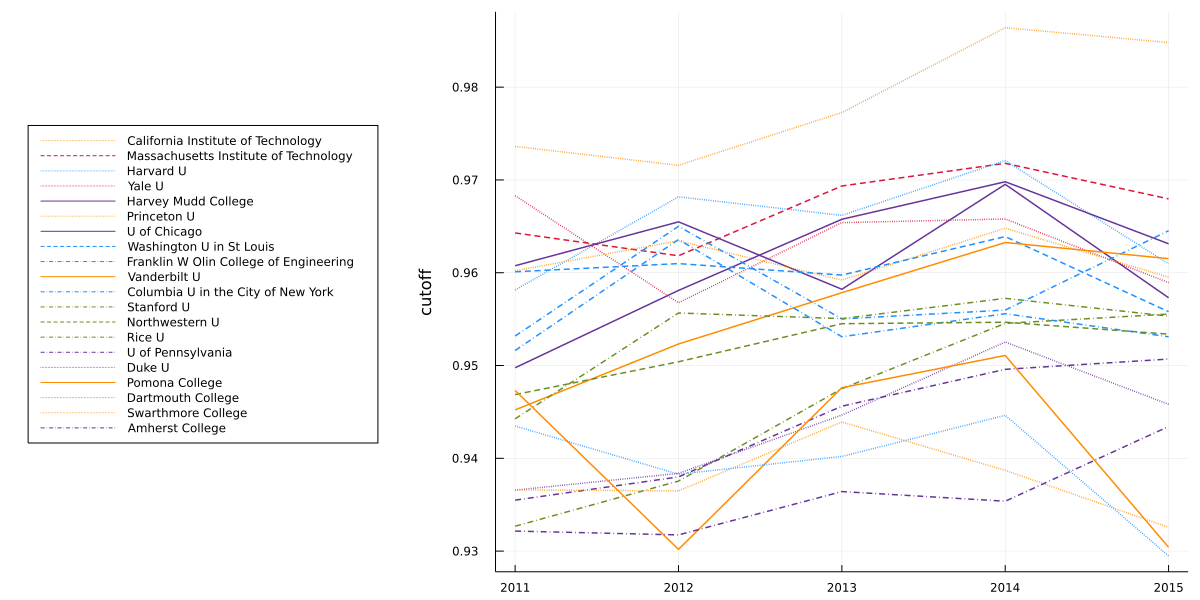

In [19]:
colors = [:crimson, :dodgerblue, :olivedrab, :rebeccapurple, :darkorange]
lines = [:solid, :dot, :dash, :dashdot]

function plot_doer(stat)
    pl = plot(size=(1200, 600), legend=:outerleft, ylabel=stat)

    for rank in partialsortperm(usadmit[!, "average"*stat], 1:20, rev=true)
        plot!(pl,
              years[1:end-4],
              [usadmit[rank, string(yr) * stat] for yr in years[1:end-4]],
              c=colors[1 + rank % length(colors)],
              ls=lines[1 + rank % length(lines)],
              lw=1.5, 
              label=usadmit[rank, "name"])
    end

    return pl
end

plot_doer("cutoff")

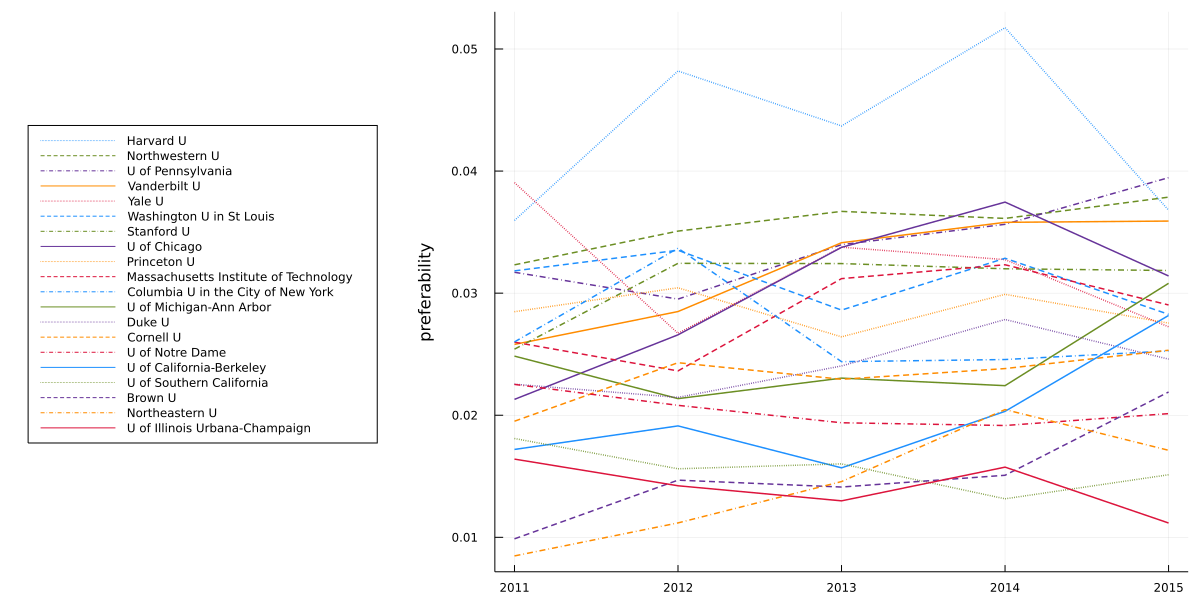

In [20]:
plot_doer("preferability")

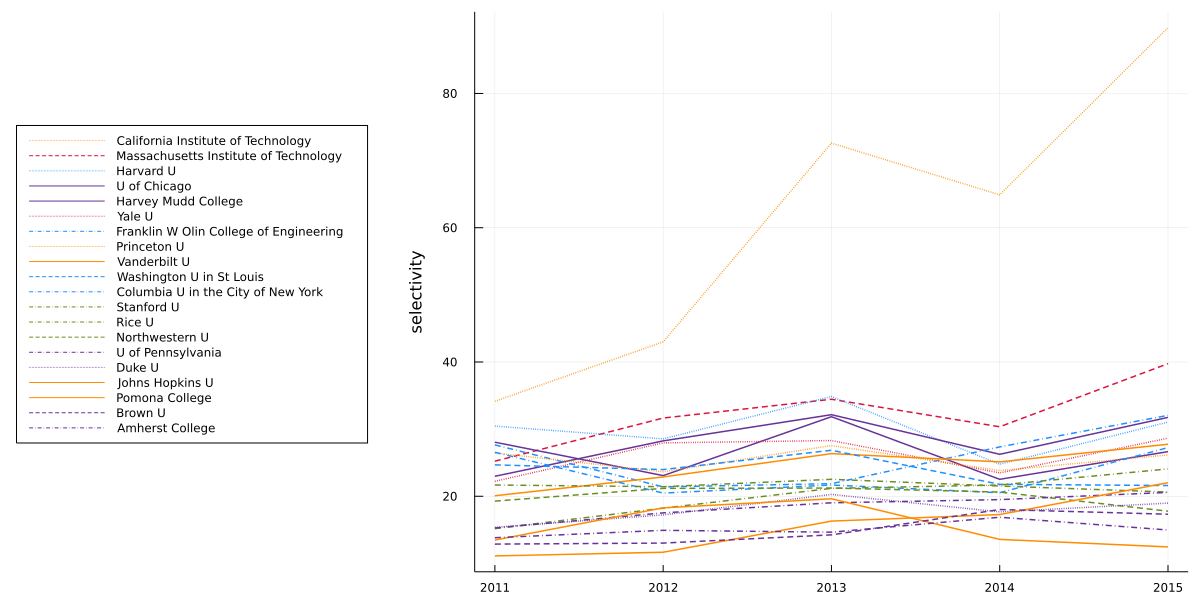

In [22]:
plot_doer("selectivity")

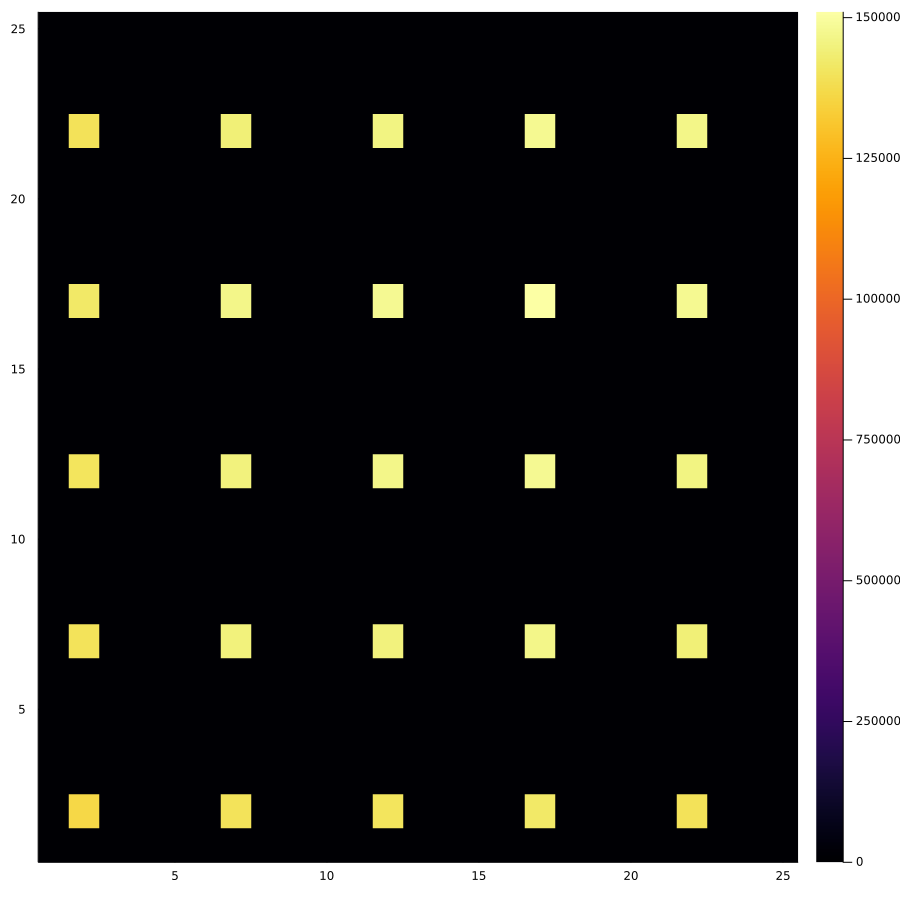

In [36]:
heatmap(cov(Matrix(usadmit[:, 2:end-5])), size=(900, 900))